In [1]:
# This script looks at the relationship between temperature and travel over
# Snoqualmie Pass (WA) by vehicle type. At the moment, it only looks at Westbound 
# travel, but it can be easily adapted to look at both. 
#
# Do more cars travel over the pass when it is warmer outside in Seattle?
# The answer is yes. What is interesting, however, is that more cars remain
# on the pass when it is colder outside, likely to go skiing.

%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# Traffic sites
road_sites = ['S901','R039W','S903','B04']

# Weather stations
weather_site = 'USW00024233'


In [2]:
# Get weather data

weather = pd.read_csv('weather_data/'+weather_site+'.csv')
weather['datetime'] = pd.to_datetime(weather.Year*10000+weather.Month*100+weather.Day, \
            format='%Y%m%d')

In [3]:
# Get and process highway data

# Get data for all sites
road_vehicle, road_speed, road_count = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for site in road_sites:
    road_vehicle = road_vehicle.append(pd.read_csv('traffic_data/'+\
            'TrafficVolumeByVehicleTypeAndHour_'+site+'_2007-01_2017-12.csv'))
    road_speed = road_speed.append(pd.read_csv('traffic_data/TrafficSpeedByHour_'+site+\
            '_2007-01_2017-12.csv'))
    road_count = road_count.append(pd.read_csv('traffic_data/TrafficVolumeByHour_'+site+\
            '_2007-01_2017-12.csv'))

# Add columns for datetime, day of year, and weekend
for frame in [road_vehicle, road_speed, road_count]:
    frame['datetime'] = pd.to_datetime(frame.Date)
    frame['DOY'] = frame['datetime'].apply(lambda x: x.timetuple().tm_yday)
    # Define weekend as Saturday/Sunday
    frame['Weekend'] = frame['datetime'].apply(lambda x: x.dayofweek > 4).astype(float)
    frame['Month'] = frame['datetime'].apply(lambda x: x.strftime("%B"))

# Get daily number of vehicles from hourly counts
frame['DailyCount'] = 0
for frame in [road_vehicle, road_count]:
    frame['DailyCount'] = frame['Hour1']
    for i in range(2,25):
        frame['DailyCount'] = frame['DailyCount']+frame['Hour'+str(i)]

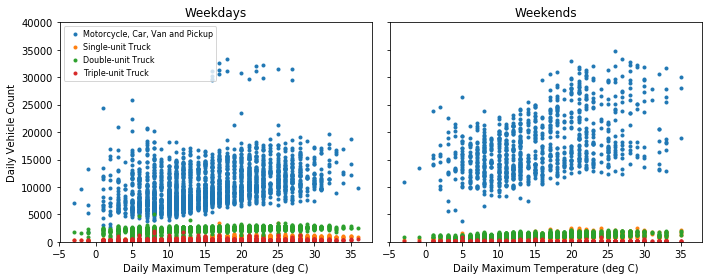

In [4]:
# Do more vehicles go over the pass when it is warm out?

# Get maximum temperature
weather_tmax = weather[weather['Type'] == 'TMAX']

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,sharex=True,figsize=(10,4))
for vehicle in road_vehicle['VehicleType'].unique():
    road_site = road_vehicle[(road_vehicle['TravelDirection']=='Westbound') &\
            (road_vehicle['SiteId'] == 'S901') & (road_vehicle['VehicleType'] == vehicle)]
    road_site_veh_wx = pd.merge(weather_tmax[['datetime','Value']],\
            road_site[['datetime','DailyCount','Weekend']],on='datetime')
    ax1.plot(road_site_veh_wx[road_site_veh_wx['Weekend'] == 0]['Value'],\
            road_site_veh_wx[road_site_veh_wx['Weekend'] == 0]['DailyCount'],'.',label=vehicle)
    ax2.plot(road_site_veh_wx[road_site_veh_wx['Weekend'] == 1]['Value'],\
            road_site_veh_wx[road_site_veh_wx['Weekend'] == 1]['DailyCount'],'.',label=vehicle)
ax1.legend(loc=2,fontsize=8,handletextpad=0.01)
ax1.set_ylim([0,40000])
ax2.set_ylim([0,40000])
ax1.set_ylabel('Daily Vehicle Count')
ax1.set_xlabel('Daily Maximum Temperature (deg C)')
ax2.set_xlabel('Daily Maximum Temperature (deg C)')
ax1.set_title('Weekdays')
ax2.set_title('Weekends')
fig.tight_layout()


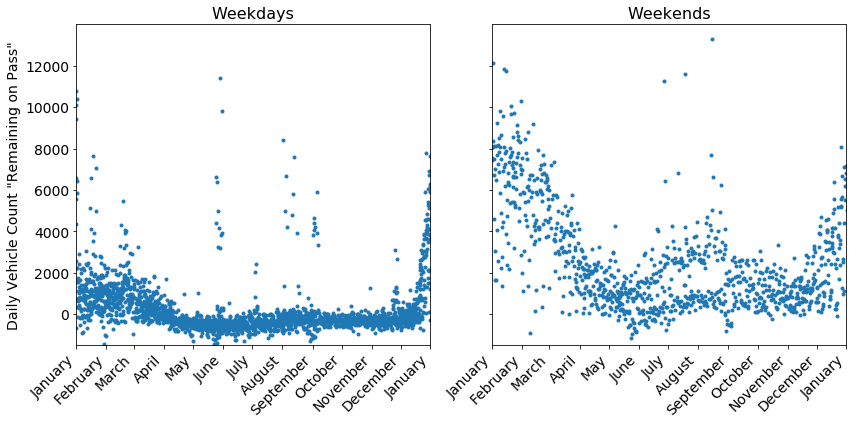

In [5]:
# So more personal vehicles travel over the pass when it is warmer outside,
# particularly during the weekends; there is no to minimal effect on commercial 
# vehicles. But are the personal vehicles staying on the pass to go hiking, skiiing, 
# etc., or driving through to Eastern WA? We can't fully answer this question 
# with the available data, but we can get an idea of the magnitude by comparing 
# daily vehicle counts at one side of the pass to the other. If vehicles pass
# by traffic stations on both sides of the pass, then those vehicles are moving 
# over the pass; otherwise, the vehicles "remain on the pass."

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,sharex=True,figsize=(12,6))
road_site1_W = road_count[(road_count['TravelDirection'] == 'Westbound') &\
    (road_count['SiteId'] == 'S901')]
road_site2_W = road_count[(road_count['TravelDirection'] == 'Westbound') &\
    (road_count['SiteId'] == 'B04')]
road_sites_W = pd.merge(road_site1_W[['datetime','DailyCount','DOY','Weekend']],\
        road_site2_W[['datetime','DailyCount']],on='datetime')
ax1.plot(road_sites_W['DOY'][road_sites_W['Weekend'] == 0],\
        (road_sites_W['DailyCount_x'][road_sites_W['Weekend'] == 0]-\
        road_sites_W['DailyCount_y'][road_sites_W['Weekend'] == 0]),'.')
ax2.plot(road_sites_W['DOY'][road_sites_W['Weekend'] == 1],\
        (road_sites_W['DailyCount_x'][road_sites_W['Weekend'] == 1]-\
        road_sites_W['DailyCount_y'][road_sites_W['Weekend'] == 1]),'.')
ax1.set_xlim([1,365])

labels_x,labels = [],[]
for month in road_site1_W['Month'].unique():
    labels_x.append(dt.datetime.strptime(str(1)+' '+month+' '+str(2011),'%d %B %Y').timetuple().tm_yday)
    labels.append(month)
labels.append(labels[0])
labels_x.append(365)
ax1.set_xticks(labels_x)
ax1.set_xticklabels(labels,rotation=45,ha="right",fontsize=14)
ax2.set_xticks(labels_x)
ax2.set_xticklabels(labels,rotation=45,ha="right",fontsize=14)
ax1.set_ylim([-1500,14000])
ax1.set_yticks(np.arange(0,12500,2000))
ax1.set_yticklabels(np.arange(0,12500,2000),fontsize=14)

ax1.set_ylabel('Daily Vehicle Count "Remaining on Pass"',fontsize=14)
ax1.set_title('Weekdays',fontsize=16)
ax2.set_title('Weekends',fontsize=16)

fig.tight_layout()
plt.savefig('figures/Snoqualmie_vehicles_on_pass.pdf')

# That's a bit of a surprising result. Despite more cars during the summer months,
# more vehicles remain on the pass during the winter, likely to go skiing
# (as evidenced by the more pronounced trend during the weekends). Looking
# at the EastBound data confirms this trend. Note that many of the random peaks
# in the middle of the year correspond to holiday weekends.